In [1]:
# Usual imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)

# OpenCV
import cv2

# Keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

# Adversarial Robustness Toolbox
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

# Other modules
from pathlib import Path
from glob import glob

# ART complains if we don't use this
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

Similar to what we did in Project 1, we will now define some constant for the path to annotations and images

In [2]:
DATA_FOLDER = Path('../data')
IMG_FOLDER = Path(DATA_FOLDER / 'tsrd-train')
ANNOTATIONS = Path(DATA_FOLDER / 'TsignRecgTrain4170Annotation.txt')
COL_NAMES = ['filename','width','height','x1','y1','x2','y2','label']
MODEL_FOLDER = Path('../Part 1')
MODEL = Path(MODEL_FOLDER / 'chinese_traffic_sign_classifier_v1.h5')

In [3]:
df = pd.read_csv(ANNOTATIONS, names=COL_NAMES, sep=';', header=None, index_col=False)

We can now load the model we created in Project 1

In [4]:
classifier = load_model(MODEL)

The ART library uses its own format for a model, so we need to create a new one that takes our model as an input. Following hints for additional parameters

In [5]:
classifier_art = KerasClassifier(model=classifier, clip_values=(0.0, 1.0), use_logits=False)

In order to create the adversarial examples, we will first import all the images. We use the same function calls from Project 1:

In [6]:
images = glob(str(IMG_FOLDER) + '/*.png')
IMG_SIZE = (134,128)

dataset = []
labels = []

for idx in range(len(images)):
    full_img_path = images[idx]
    filename = Path(full_img_path).name
    img_bgr = cv2.imread(full_img_path)
    image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    image = img_to_array(image)
    dataset.append(image)
    # get label specific to this image
    row = df[df['filename'] == filename]
    label = row['label'].values[0]
    if row.empty:
        print(filename)
    else:
        labels.append(label)

dataset = np.array(dataset) / 255.0
labels = to_categorical(labels)

Before saving the model as we did in Project 1, we will create the split between training and test data.

In [7]:
(train_X, valid_X, train_Y, valid_Y) = train_test_split(dataset, labels,
                                                        test_size=0.2, stratify=labels)

np.savez('../data/chinese_traffic_sign_dataset_2.npz', train_X=train_X, valid_X=valid_X,
         train_Y=train_Y, valid_Y=valid_Y)

Ok, we are now ready to generate malicious examples from the training data. We will use the two methods presented in the milestone description, and we will compare them with the original data points as well as with examples corrupted with random uniform noise.

In [8]:
EPSILON = 0.03

num_samples = 50 # hints recommendation says 10, though

fgsm = FastGradientMethod(estimator=classifier_art, eps=EPSILON)
valid_X_fgsm = fgsm.generate(x=valid_X)

#Following hints recommendation
pgd = ProjectedGradientDescent(estimator=classifier_art, eps=EPSILON, eps_step=0.01,
                               max_iter=40, targeted=False, num_random_init=True)
valid_X_pgd = pgd.generate(x=valid_X[:num_samples])

/usr/local/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

In [9]:
valid_X_uniform_noise = valid_X + np.random.uniform(low=-EPSILON, high=EPSILON, size=valid_X.shape)

We are now ready to make our predictions on the different validation data. We will print the accuracy of our classifier on the original data, the noise corrputed data, and the malicious samples created using the two attack methods chosen

In [10]:
pred_base = classifier_art.predict(valid_X)
pred_noise = classifier_art.predict(valid_X_uniform_noise)
pred_fgsm = classifier_art.predict(valid_X_fgsm)
pred_pgd = classifier_art.predict(valid_X_pgd)

In [11]:
acc_base = np.sum(np.argmax(pred_base, axis=1) == np.argmax(valid_Y, axis=1)) / len(valid_Y)
acc_noise = np.sum(np.argmax(pred_noise, axis=1) == np.argmax(valid_Y, axis=1)) / len(valid_Y)
acc_fgsm = np.sum(np.argmax(pred_fgsm, axis=1) == np.argmax(valid_Y, axis=1)) / len(valid_Y)
# less samples for pgd
acc_pgd = np.sum(np.argmax(pred_pgd, axis=1) == np.argmax(valid_Y[:num_samples], axis=1)) / num_samples
print(f"Accuracy on validation dataset: {acc_base * 100:.2f}%")
print(f"Accuracy on noisy dataset: {acc_noise * 100:.2f}%")
print(f"Accuracy on fgsm-corrupted dataset: {acc_fgsm * 100:.2f}%")
print(f"Accuracy on pgd-corrupted dataset: {acc_pgd * 100:.2f}%")

Accuracy on validation dataset: 98.56%
Accuracy on noisy dataset: 98.44%
Accuracy on fgsm-corrupted dataset: 40.41%
Accuracy on pgd-corrupted dataset: 18.00%


Now we plot examples of the images, together with the label from the classifier

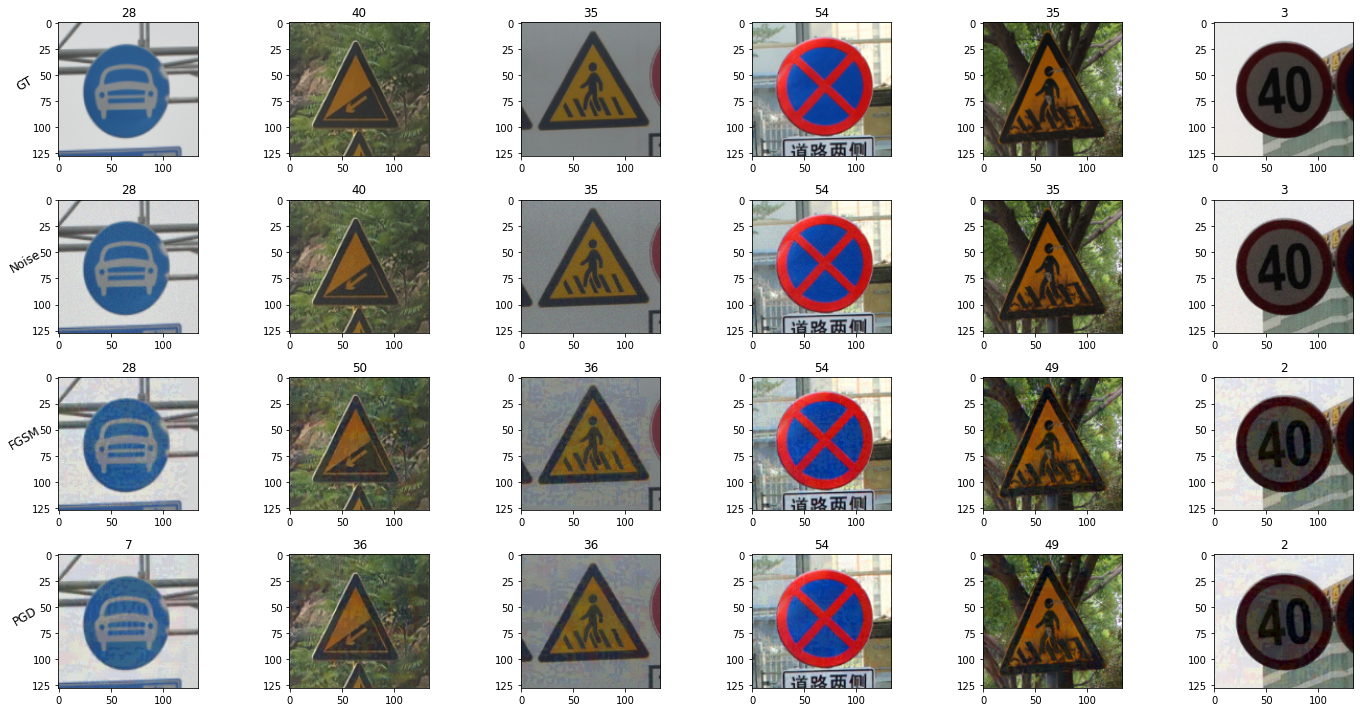

In [12]:
ROWS = 4
COLS = 6
fig, axes = plt.subplots(ROWS, COLS, figsize=(20, 10))

row_labels = ['GT', 'Noise', 'FGSM', 'PGD']

for k in range(COLS):
    axes[0,k].imshow(valid_X[k])
    axes[1,k].imshow(valid_X_uniform_noise[k].clip(0.0,1.0)) #.clip(0.0,1.0)
    axes[2,k].imshow(valid_X_fgsm[k])
    axes[3,k].imshow(valid_X_pgd[k])
    
    axes[0,k].set_title(str(pred_base[k].argmax()))
    axes[1,k].set_title(str(pred_noise[k].argmax()))
    axes[2,k].set_title(str(pred_fgsm[k].argmax()))
    axes[3,k].set_title(str(pred_pgd[k].argmax()))
    
for ax, row in zip(axes[:,0], row_labels):
    ax.set_ylabel(row, rotation=30, size='large')

fig.tight_layout()
plt.show()

Finally, we save everything we will need for Milestone 2. The input data (split into training and validation set), the samples corrupted by noise or through FGSM and PGD, as well as the predictions made over the corrupted validation datasets.

In [13]:
np.savez('../data/chinese_traffic_sign_dataset_2.npz', train_X=train_X, valid_X=valid_X,
         train_Y=train_Y, valid_Y=valid_Y, pred_base=pred_base, pred_noise=pred_noise, pred_fgsm=pred_fgsm,
         pred_pgd=pred_pgd, valid_X_uniform_noise=valid_X_uniform_noise, valid_X_fgsm=valid_X_fgsm,
         valid_X_pgd=valid_X_pgd)